In [1]:
%matplotlib inline
# Plot everything as SVG
%config InlineBackend.figure_formats=['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure some styling
palette = ['#386DF9', '#FFDC52', '#FF1614', '#62F591', '#AA22FF', '#34495E']
sns.set(font_scale=1.1, style='darkgrid', palette=palette, context='notebook')

# We'll use this later to visualize lines
def make_line(m, b, frm=0, to=200):
    xs = np.linspace(frm, to, 500)
    ys = np.dot(xs[:,np.newaxis], [m]) + b
    return xs, ys

# Classification

A common problem is _classification_, given some data about a thing, how should I label it?

We are going to continue using a supervised learning approach for classification, though it is possible to use unsupervised approaches (such as clustering, which we will explore later).

Like regression, classification involves learning a function, though this time, we are not looking for the function that aligns with the data as we did before. Instead we are looking for a function which _divides_ the data such that one class is on one side of it and the other class is on the other side.

This dividing function is called the __decision boundary__.

### Example: Classifying deer

![](../assets/sawsbuck2.png)

To introduce you to the process, let's go back to our deer research.

We've collected some data about two species of deer and their weights and heights. But for some data points, we've only have the weight and height and forgot to write what species they were.

Using only its weight and height, can we predict what species a deer belongs to?


In [2]:
deer_data = pd.read_csv('../data/deer_species_data.csv')
deer_data.head()

,Weight,Height,Species
0,188.693080,220.523927,1
1,218.089266,173.806123,0
2,185.550693,218.227736,1
3,183.831915,220.421194,1
4,167.150952,216.111407,1


Note that our species values are encoded using numbers, $0, 1$, rather than the species names themselves. Transforming our classes into integers allows us to work with them more easily.

When discussing classes, class 0 is typically referred to as the "negative" class, and class 1 as the "positive" class.

Let's plot our weight and height data to see if they seem to be good at distinguishing the species. If so, we expect there to be some clear separation - that is, we expect to see some obvious clusters.

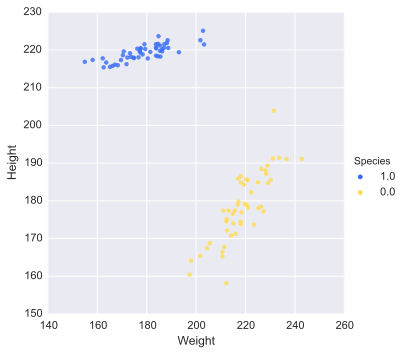

In [3]:
sns.lmplot('Weight', 'Height', data=deer_data, fit_reg=False, hue='Species')

There is a great deal of separation here, which means weight and height are enough to distinguish the two species. It should not be difficult to find a good decision boundary here.

Again, we want to find the _parameters_ that define this line. A common technique for classification is __logistic regression__.

You may note that "regression" is in the name – logistic regression does give us a continuous value, but that value represents the probability of a datapoint being in class 1, so it is used for classification.

For instance, it may output 0.7424 for a datapoint, which means that datapoint should be classified as 1. If it outputs something small, such as 0.1563, that means that datapoint should be classified as 0.



In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# Again, split into training and test set
# (set random state for the purposes of demonstration)
train, test = train_test_split(deer_data[['Height', 'Weight', 'Species']], train_size=0.7, random_state=1000)
X_train = train[['Height', 'Weight']]
y_train = train['Species']

model = LogisticRegression()
model.fit(X_train, y_train)

m = model.coef_[0]
b = model.intercept_

print('m', m)
print('b', b)

m [ 0.24501083 -0.24068343]
b [-0.00027016]


So our resulting function is:

$$
y = 0.245x_1 - 0.241x_2
$$

This is in three dimensions, but we can set $y=0$ to plot it in 2d.

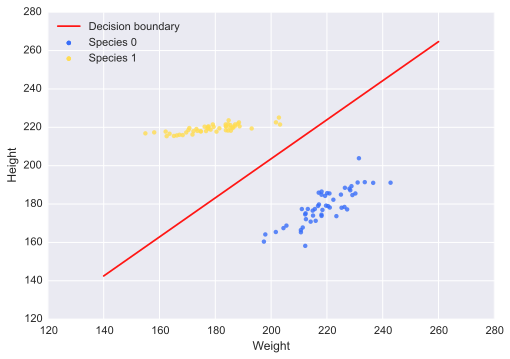

In [6]:
# Solve for y = m_1x_1 + m_2x_2 + b, where y=0, so we can plot this in 2D
def func(x):
    return -(m[0]*x + b)/m[1]

xs = np.linspace(140, 260, 500)
ys = func(xs)

species_0 = deer_data[deer_data['Species'] == 0]
species_1 = deer_data[deer_data['Species'] == 1]
sns.regplot(species_0['Weight'], species_0['Height'], fit_reg=False, label='Species 0')
sns.regplot(species_1['Weight'], species_1['Height'], fit_reg=False, label='Species 1')
plt.plot(xs, ys, label='Decision boundary')
plt.legend(loc=2)

### Measuring wrongness


So how did we do? With regression problems, we used the mean squared error to quantify our success.

With classification, we have a different set of techniques. With classification, the two ways we can be wrong are:

- Saying the point belongs to class 1 when it doesn't (__false positive__). For example, saying an email is "spam" when it isn't.
- Saying the point doesn't belong to class 1 when it does (__false negative__). For example, saying an email is "not spam" when it is.

When we guess that a point belongs to class 1 and it does, we call that a __true positive__. When a point doesn't belong to class 1 and we correctly guess that, we call that a __true negative__.

We can view the true positives and negatives and the false positives and negatives together in what is called a __confusion matrix__.

In [1]:
from sklearn import metrics

X_test = test[['Height', 'Weight']]
y_test = test['Species']
y_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
cm

NameError: name 'test' is not defined

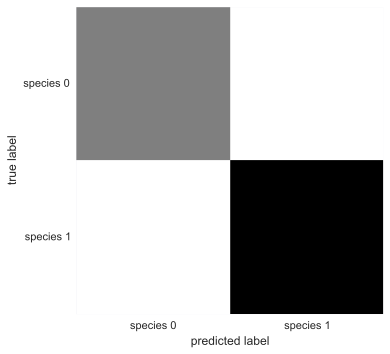

In [27]:
plt.imshow(cm, interpolation='nearest')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.xticks([0,1],['species 0', 'species 1'])
plt.yticks([0,1],['species 0', 'species 1'])
plt.grid(False)

Other common measurements include:

- __recall__ - what fraction of the true class 1 items were properly identified as such?
- __precision__ - what fraction of items identified as class 1 were truly class 1?

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/330px-Precisionrecall.svg.png) (source: [Wikipedia](https://commons.wikimedia.org/wiki/File:Precisionrecall.svg))

In [28]:
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision, recall

(1.0, 1.0)

The recommended way, however, is to use the __area under the (ROC) curve__ (AUC).

![](../assets/roc.jpg) ([source](http://gim.unmc.edu/dxtests/roc3.htm))

The AUC plots the false positive rate against the true positive rate for your classifier.

If you make more classifier more lenient in what it classifies positively, _both_ the true positive and false positive rates will increase. A good classifier, however, will have a greater increase in true positives than in false positives.

For example, in the "excellent" curve above, you can see that the true positive rate shoots up quickly when the false positive rate increases only a little.

The "worthless" curve above represents an AUC score of 0.5, which is achieved if your classifier just makes random guesses.

An AUC score of 1.0 is perfect.

In [29]:
metrics.roc_auc_score(y_test, y_pred)

1.0

---

# Exercise: Classifying "latent" criminals

We've got a pretty close approximation of the crime coefficient formula. Now we want to see if the crime coefficient is actually a good predictor of criminal behavior. In our semi-fictionalized world, if someone is predicted to commit a crime, but has not yet committed one, they are labeled as a "latent criminal".

We have access to public criminal records and to the crime coefficients from before. We'll say `criminal_behavior=1` if someone has been convicted of a crime in the past, otherwise `criminal_behavior=0`.

This is a classification problem. Given an individual's crime coefficient, we want to _classify_ them as a criminal (`criminal_behavior=1`) or not (`criminal_behavior=0`).

We can apply this technique to identify "latent criminals" as described above.

In our semi-fictionalized world, individuals are also assigned a "hue", which is a color indicating their stress level.

![](../assets/hue.png)

Our world is simple and we don't use a full RGB color - we just use gray scale colors, so that someone's hue is represented by one value from 0-255.

According to justice policy, the crime coefficient and hue together are precise predictors of crime; they are used to arrest people prior to the predicted crime ever taking place (much like in Minority Report).

Leveraging public records, we assembled a dataset of people's crime coefficients, hues and whether or not they were convicted of a crime.

Try applying logistic regression to see if you can successfully classify criminals based on their crime coefficients and hues.

(Note: we _could_ use simpler means of computing the correlation between the crime coefficient/hue and criminal behavior, but since this is an introduction to machine learning, we'll use a different technique here.)

In [7]:
criminal_data = pd.read_csv('../data/criminalbehavior.csv')
criminal_data.head()

,crime_coef,hue,criminal_behavior
0,10.099342,62.973679,0
1,49.455816,15.848373,0
2,39.200911,16.542826,1
3,39.941107,86.619647,1
4,29.957060,32.906168,1


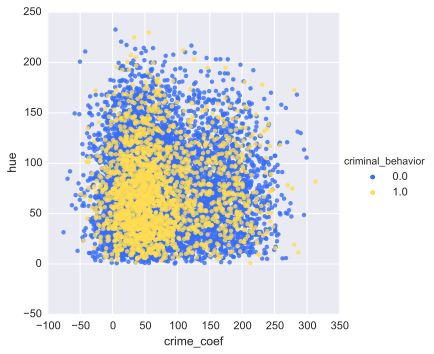

In [8]:
sns.lmplot('crime_coef', 'hue', data=criminal_data, fit_reg=False, hue='criminal_behavior')

In [30]:
# (set random state for the purposes of demonstration)
train, test = train_test_split(criminal_data[['crime_coef', 'hue', 'criminal_behavior']], train_size=0.7, random_state=1000)
X_train = train[['crime_coef', 'hue']]
y_train = train['criminal_behavior']

model = LogisticRegression()
model.fit(X_train, y_train)

m = model.coef_[0]
b = model.intercept_

print('m', m)
print('b', b)

m [-0.00019223 -0.00090236]
b [-1.28724913]


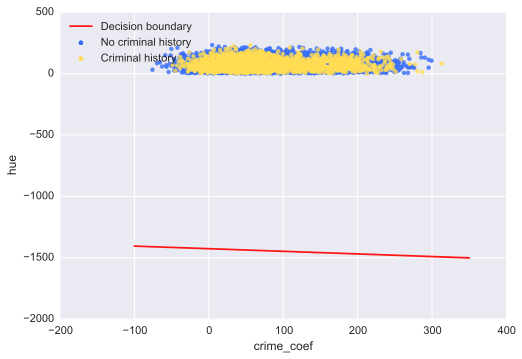

In [31]:
# Solve for y = m_1x_1 + m_2x_2 + b, where y=0, so we can plot this in 2D
def func(x):
    return -(m[0]*x + b)/m[1]

xs = np.linspace(-100, 350, 500)
ys = func(xs)
non_crim = criminal_data[criminal_data['criminal_behavior'] == 0]
crim = criminal_data[criminal_data['criminal_behavior'] == 1]
sns.regplot(non_crim['crime_coef'], non_crim['hue'], fit_reg=False, label='No criminal history')
sns.regplot(crim['crime_coef'], crim['hue'], fit_reg=False, label='Criminal history')
plt.plot(xs, ys, label='Decision boundary')
plt.legend(loc=2)

In [32]:
# See how we did
X_test = test[['crime_coef', 'hue']]
y_test = test['criminal_behavior']
y_pred = model.predict(X_test)
metrics.roc_auc_score(y_test, y_pred)

0.5

In [36]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[2388,    0],
       [ 612,    0]])

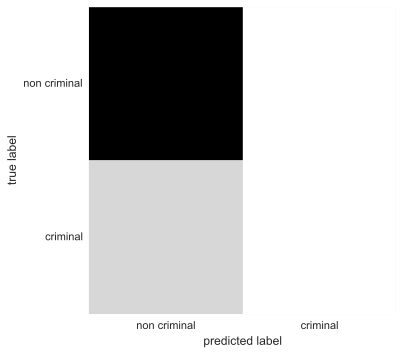

In [38]:
plt.imshow(cm, interpolation='nearest')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.xticks([0,1],['non criminal', 'criminal'])
plt.yticks([0,1],['non criminal', 'criminal'])
plt.grid(False)